# Amazon Best Sellers - Exploratory Data Analysis

This notebook performs exploratory data analysis on Amazon best-sellers data scraped from multiple categories. The analysis examines product rankings, pricing patterns, review distributions, and brand performance.

## Setup and Database Connection

First, we establish a connection to the PostgreSQL database where our scraped data is stored.

In [175]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create pics directory if it doesn't exist
os.makedirs('pics', exist_ok=True)

# Database credentials
dbname = 'amazon_scraping_db'
user = 'admin'
password = 'admin123'
host = 'localhost' # Use 'localhost' if running locally. For cloud notebooks (like Colab) or remote servers, you may need a different hostname/method.
port = '5432' # Default PostgreSQL port

# Create the connection engine
connection_string = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"
engine = create_engine(connection_string)

def read_sql(query):
    return pd.read_sql(query, engine)


print("Connection established successfully!")


Connection established successfully!


## Initial Data Exploration

Let's start by examining the `category_metrics` table to understand the overall dataset structure and key metrics per category.

In [176]:
# Example SQL query
sql_query = """
SELECT *
FROM analytics.category_metrics;
"""

# Execute the query and load results into a pandas DataFrame
df = read_sql(sql_query)

# Display the data
df.head()


,category,products,avg_rank,avg_price
0,best_sellers_amazon_renewed,111,48.251309,4515.521832
1,best_sellers_computers_accessories,110,50.000000,856.129793
2,best_sellers_electronics,100,48.401070,395.616588


# Data quality
From the raw data we can see
- Total number of products
- Number of categories
- %  of reviews
- % of prices



### Product Count by Category

This query shows the distribution of products across different categories, helping us understand which categories have the most representation in our dataset.

In [177]:
query_total_products = """
SELECT
    category,
    COUNT(*) AS products
FROM core.products
GROUP BY category
ORDER BY products DESC;
"""
df_total_products = read_sql(query_total_products)
print("Total products by category:")
df_total_products


Total products by category:


,category,products
0,best_sellers_amazon_renewed,111
1,best_sellers_computers_accessories,110
2,best_sellers_electronics,100


### Data Completeness

These queries calculate the percentage of products that have complete price history and product details. This helps assess data quality and pipeline effectiveness.

In [178]:

query_percentage_price = """
SELECT
    COUNT(*) FILTER (WHERE has_price_history) * 100.0 / COUNT(*) 
        AS pct_with_price_history
FROM core.products;
"""
query_percentage_details = """
SELECT
    COUNT(*) FILTER (WHERE has_details) * 100.0 / COUNT(*) 
        AS pct_with_details
FROM core.products;
"""

percentage_price = read_sql(query_percentage_price)
percentage_details = read_sql(query_percentage_details)
print("Percentage of products with price history:",percentage_price["pct_with_price_history"].iloc[0] )
print("Percentage of products with details:",percentage_details["pct_with_details"].iloc[0] )

Percentage of products with price history: 98.13084112149532
Percentage of products with details: 99.68847352024922


These initial metrics provide a high-level overview of the dataset size, category coverage, and data completeness. The results indicate that the pipeline captures a broad set of products.

## Data frame by category

### Statistical Summary

Loading the latest product rank data to perform statistical analysis. This view contains the most recent ranking information for all products, including their current price and position.

In [179]:
query_latest_rank = 'SELECT * FROM analytics.latest_product_rank;'
df_latest_rank = read_sql(query_latest_rank)
df_latest_rank.describe()

,rank_position,scraped_at,price_on_date
count,608.000000,608,587.000000
mean,49.875000,2026-02-01 02:55:48.074513,2067.540358
min,1.000000,2026-01-29 15:39:05.618560,5.980000
25%,25.000000,2026-02-01 10:22:41.280284,185.505000
50%,50.000000,2026-02-01 10:23:32.324496,599.950000
75%,74.250000,2026-02-01 10:24:19.644551,2940.870000
max,99.000000,2026-02-01 10:24:19.644551,14735.370000
std,28.305247,NaN,2801.958945


### Category-Specific Statistics

Here we generate descriptive statistics for each category individually to identify category-specific patterns in pricing, rankings, and ratings.

In [180]:
for i in df_total_products['category']:
    print(i)
    print(df_latest_rank[df_latest_rank['category'] == i].describe())
    print("\n")

best_sellers_amazon_renewed
       rank_position                  scraped_at  price_on_date
count     207.000000                         207     207.000000
mean       49.169082  2026-02-01 00:03:59.383714    4604.468744
min         1.000000  2026-01-29 15:40:29.011851      88.480000
25%        24.000000  2026-02-01 10:22:41.280284    2219.260000
50%        50.000000  2026-02-01 10:22:41.280284    3652.170000
75%        74.000000  2026-02-01 10:22:41.280284    5992.880000
max        95.000000  2026-02-01 10:22:41.280284   14735.370000
std        27.713433                         NaN    3254.037202


best_sellers_computers_accessories
       rank_position                  scraped_at  price_on_date
count     209.000000                         209     203.000000
mean       50.842105  2026-02-01 03:22:01.092292     917.748325
min         1.000000  2026-01-29 15:39:05.618560       8.980000
25%        26.000000  2026-02-01 10:23:32.324496     173.000000
50%        50.000000  2026-02-01 10:23:

## For the last rank date available

### Price Distribution by Category and Brand

These distribution plots show how prices vary within each category, broken down by brand. This helps identify:
- Price ranges for different product categories
- Which brands dominate specific price points
- Outliers and pricing patterns

In [181]:
query_latest_rank = "SELECT * FROM analytics.latest_product_rank;"
df_latest_rank = read_sql(query_latest_rank)
for i in df_total_products['category']:
    g = sns.displot(df_latest_rank[df_latest_rank['category'] == i], x = "price_on_date", hue="brand", ).set(title=f"Price Distribution for {i}")
    plt.savefig(f'pics/price_distribution_{i.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
    plt.close()

### Overall Price Distribution

A combined view of price distributions across all categories to identify general pricing trends and compare categories side-by-side.

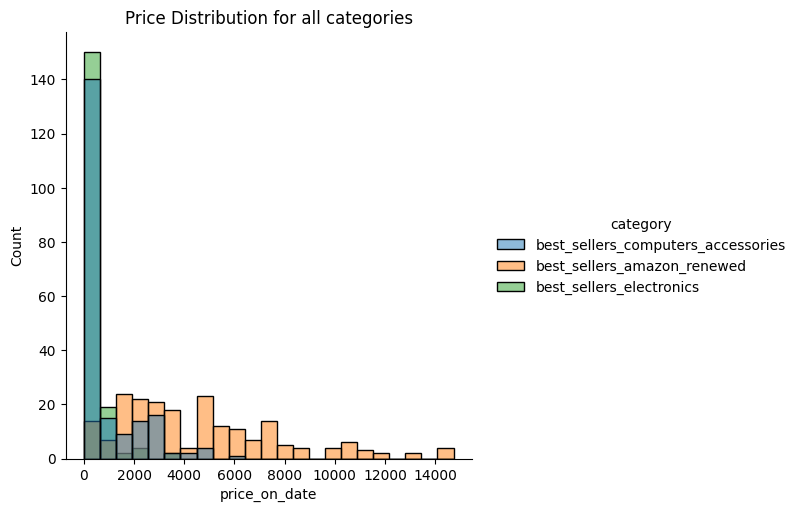

In [182]:
g = sns.displot(df_latest_rank , x = "price_on_date", hue="category", ).set(title=f"Price Distribution for all categories")
plt.savefig('pics/price_distribution_all_categories.png', dpi=300, bbox_inches='tight')
plt.show()

### Price Comparison Across Categories

Box plots provide a clear comparison of price ranges, medians, and outliers across different product categories.

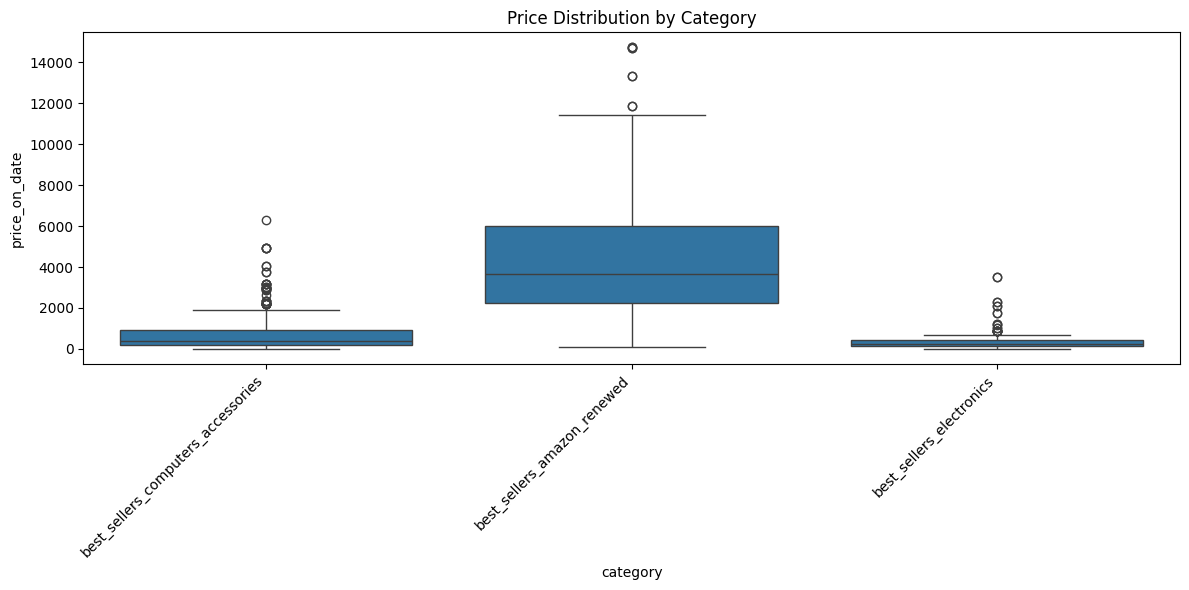

In [183]:
plt.figure(figsize=(12, 6))
sns.boxplot(x = 'category', y = 'price_on_date', data = df_latest_rank).set(title="Price Distribution by Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('pics/price_boxplot_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

## Rankings statistics

This analysis examines how products perform in the rankings over time. We calculate statistical measures like average rank, median rank, standard deviation, and range to understand ranking stability and volatility.

### Ranking Performance Metrics

For each product, we calculate:
- **Average rank**: Overall ranking performance
- **Median rank**: Middle value, less affected by outliers
- **Standard deviation**: Measures ranking volatility (higher = more volatile)
- **Rank range**: Difference between best and worst ranking
- **Observations**: Number of times the product appeared in rankings

In [184]:
rank_stats_query = """ 
SELECT
    prh.asin,
    p.product_name,
    p.category,
    AVG(prh.rank_position) AS avg_rank,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY prh.rank_position) AS median_rank,
    STDDEV_POP(prh.rank_position) AS std_rank,
    MAX(prh.rank_position) - MIN(prh.rank_position) AS rank_range,
    COUNT(*) AS observations
FROM core.product_rank_history prh
JOIN core.products p USING (asin)
GROUP BY prh.asin, p.product_name, p.category;
"""
rank_stats = read_sql(rank_stats_query)
rank_stats.head()

,asin,product_name,category,avg_rank,median_rank,std_rank,rank_range,observations
0,B00DI89WDW,KabelDirekt TOSLINK – Optical Audio Cable – 6f...,best_sellers_electronics,96.5,96.5,1.5,3,2
1,B00EB4ADQW,FUJIFILM Instax Mini Instant Film Twin Pack (W...,best_sellers_electronics,17.5,17.5,0.5,1,2
2,B00NNMB3KS,"havit HV-F2056 15.6""-17"" Laptop Cooler Cooling...",best_sellers_computers_accessories,28.0,28.0,1.0,2,2
3,B00SFSU53G,Mounting Dream TV Wall Mount for 32-65 Inch Te...,best_sellers_electronics,48.5,48.5,0.5,1,2
4,B00TP1C1UC,"Amazon Basics Surge Protector Power Strip, 6-O...",best_sellers_electronics,25.5,25.5,3.5,7,2


### Most Volatile Products

Products with high standard deviation in their ranking are the most volatile - their position fluctuates significantly over time. This could indicate:
- Seasonal demand patterns
- Competitive pressure
- Inconsistent quality or reviews
- Price changes affecting demand

In [185]:
rank_stats.sort_values("std_rank", ascending=False).head(5)


,asin,product_name,category,avg_rank,median_rank,std_rank,rank_range,observations
318,B0FXTWF1HV,100Pcs Holographic Valentines Stickers for Kid...,best_sellers_computers_accessories,63.5,63.5,24.5,49,2
310,B0FHWKYT89,"Wireless Earbuds, Bluetooth 5.4 Headphones Bas...",best_sellers_electronics,54.0,54.0,22.0,44,2
137,B0B8NV2TDJ,Roku Ultra | The Ultimate Streaming Device 4K/...,best_sellers_amazon_renewed,67.5,67.5,16.5,33,2
216,B0CSXV3GK4,Wireless Earbuds 75hrs Bluetooth 5.4 Headphone...,best_sellers_electronics,67.5,67.5,16.5,33,2
67,B08RYXFQDT,Mac Book Pro Charger - 96W USB C Charger Fast ...,best_sellers_computers_accessories,79.0,79.0,15.0,30,2


## Top 10 Performance Analysis

This section analyzes products that have appeared in the top 10 rankings, examining their characteristics and patterns.

### Price Distribution of Top-Performing Products

Examining the price distribution of products that made it to the top 10 rankings, segmented by category. This reveals which price points are most successful in each category.

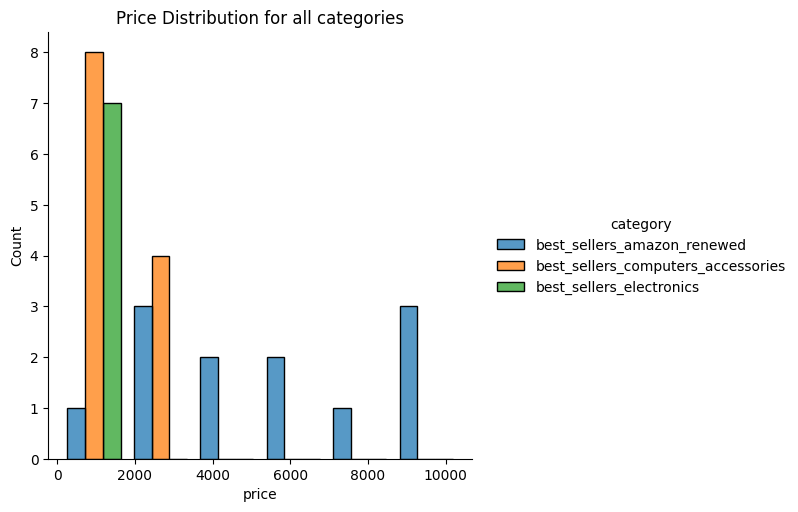

In [186]:
df_total_times_top= read_sql("SELECT * FROM analytics.times_in_top;")
g = sns.displot(df_total_times_top , x = "price", hue="category" , multiple='dodge', shrink=0.8 ).set(title=f"Price Distribution for all categories")
plt.savefig('pics/top10_price_distribution_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

### Brand Performance in Top 10

This chart shows which brands most frequently appear in the top 10 rankings across all categories, indicating brand strength and market dominance.

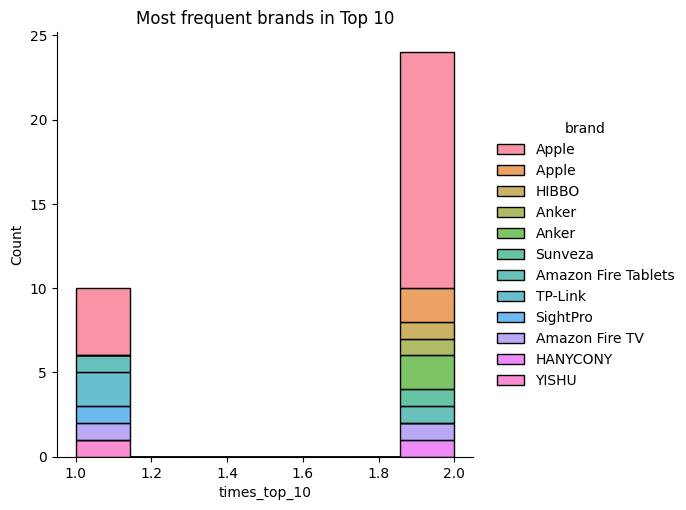

In [187]:
g = sns.displot(df_total_times_top , x = "times_top_10", hue="brand", multiple='stack' ).set(title=f"Most frequent brands in Top 10")
plt.savefig('pics/brand_frequency_top10.png', dpi=300, bbox_inches='tight')
plt.show()

### Price Ranges of Top Products by Category

A box plot comparison showing the typical price ranges for products that achieve top rankings in each category.

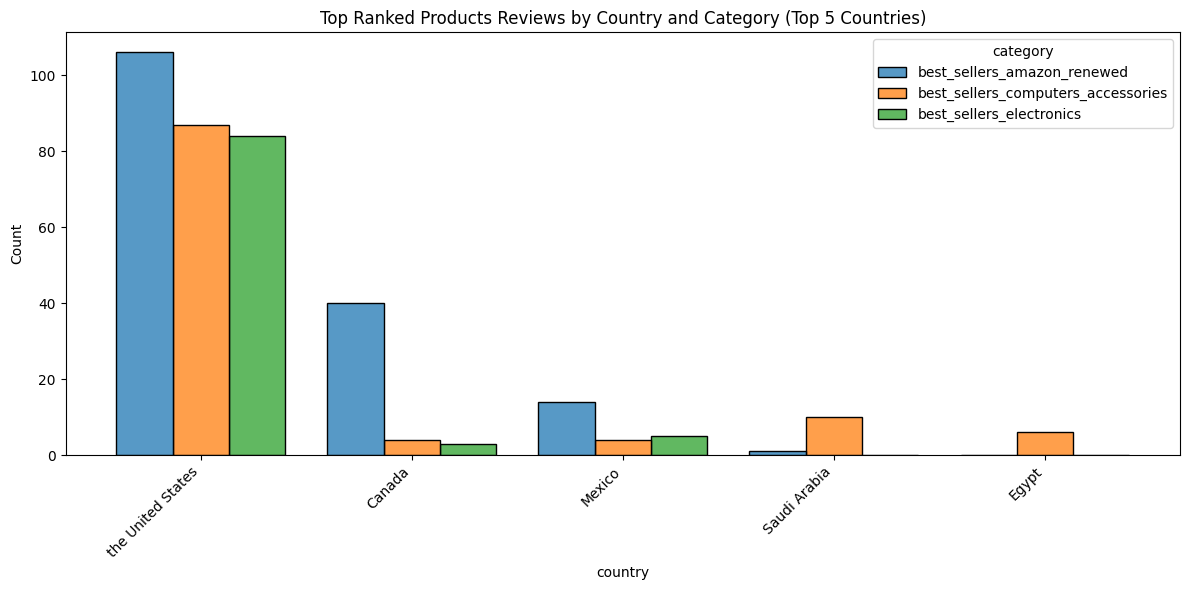

In [188]:
df_reviews_top = read_sql("SELECT * FROM analytics.top_ranked_products_reviews;")

# Filtrar los 5 países principales por frecuencia
top_countries = df_reviews_top['country'].value_counts().head(5).index
df_reviews_top_filtered = df_reviews_top[df_reviews_top['country'].isin(top_countries)]

# Generar el gráfico solo para los 5 países principales
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_reviews_top_filtered, 
    x="country", 
    hue="category", 
    multiple="dodge", 
    shrink=0.8
).set(title="Top Ranked Products Reviews by Country and Category (Top 5 Countries)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('pics/top_products_reviews_by_country.png', dpi=300, bbox_inches='tight')
plt.show()

### Overall Review Distribution by Country

Comparing the review distribution across all products (not just top-ranked) to identify:
- Which markets generate the most reviews
- Whether top-ranked products have different geographic patterns than the overall dataset
- Category preferences by country

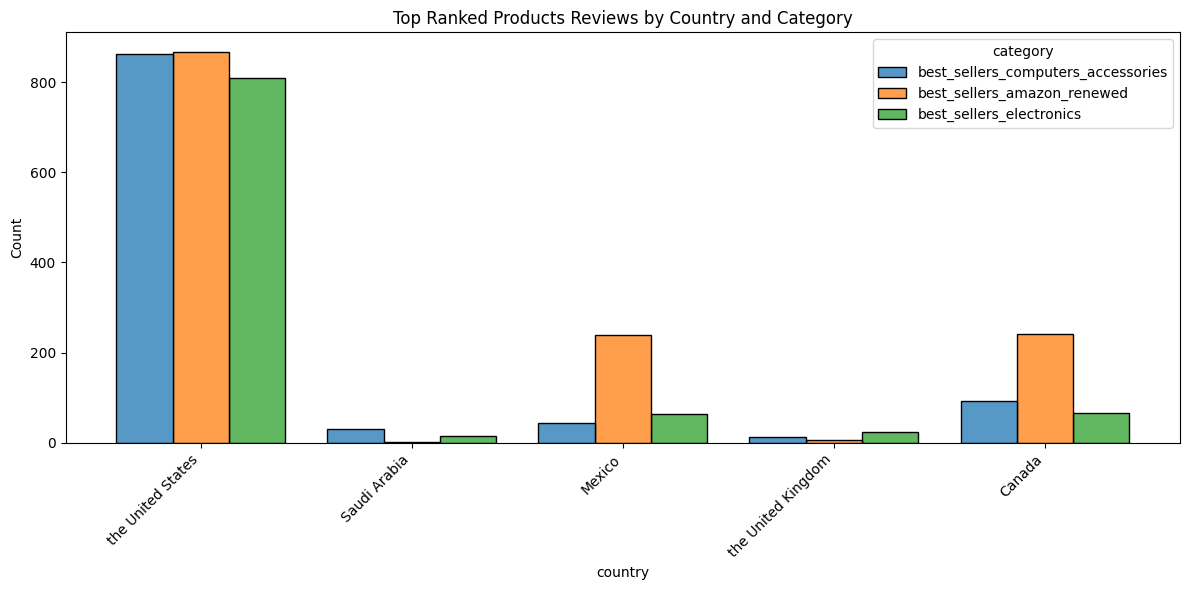

In [189]:
df_all_reviews = read_sql("""
SELECT core.products.category , raw.reviews.country
FROM core.products 
LEFT JOIN raw.reviews ON core.products.asin = raw.reviews.asin;
""")

# Filtrar los 5 países principales por frecuencia
top_countries = df_all_reviews['country'].value_counts().head(5).index
df_reviews_top_filtered = df_all_reviews[df_all_reviews['country'].isin(top_countries)]

# Generar el gráfico solo para los 5 países principales
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_reviews_top_filtered, 
    x="country", 
    hue="category", 
    multiple="dodge", 
    shrink=0.8
).set(title="Top Ranked Products Reviews by Country and Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('pics/all_products_reviews_by_country.png', dpi=300, bbox_inches='tight')
plt.show()

## Key Findings and Next Steps

### Summary
This exploratory analysis has revealed:
1. **Data Quality**: Coverage of price history and product details across categories
2. **Price Patterns**: Distinct pricing strategies per category and brand
3. **Ranking Volatility**: Products with stable vs. fluctuating rankings
4. **Top Performers**: Characteristics of products that reach top 10
5. **Geographic Patterns**: Review distribution across key markets

### Potential Next Steps
- Time series analysis of ranking changes
- Correlation analysis between price, reviews, and ranking
- Predictive modeling for ranking performance
- Deeper category-specific analysis
- Seasonal trend identification